## [Auditory modeling in PyTorch](https://github.com/msaddler/auditory_model_tutorial)

<a href="https://colab.research.google.com/github/msaddler/auditory_model_tutorial/blob/main/DEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2025 msaddler. MIT license.


In [1]:
"""
Import standard Python packages
"""

import glob
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import torch
import tqdm


In [ ]:
"""
If running this notebook in Google Colab, run this cell to
clone the `auditory_model_tutorial` repository into the 
current runtime and set it to be the working directory.
"""

!git clone https://github.com/msaddler/auditory_model_tutorial.git
%cd auditory_model_tutorial
!ls -1


In [2]:
"""
Import `filters.py`, `modules.py`, and `utils.py` as Python modules.
These scripts contain useful functions and classes that can be called
from this notebook once imported.
"""

import utils
import filters
import modules


In [23]:
"""
Check if a GPU is available in the current runtime and define `device`.
"""

import importlib
importlib.reload(utils)
importlib.reload(filters)
importlib.reload(modules)

# device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [24]:
"""
This repository includes a small dataset of example sound files
(speech waveforms stored as wav files), which can be loaded and
played in the notebook.
"""

list_filename = glob.glob("data/*.wav")
print(f"Found {len(list_filename)} wav files in the data directory")
filename = list_filename[-1]
x, sr = sf.read(filename)
print(f"Loaded `{filename}`: {x.shape=}, {x.dtype=}, {sr=} Hz")
ipd.display(ipd.Audio(rate=sr, data=x))


Found 100 wav files in the data directory
Loaded `data/099.wav`: x.shape=(40000,), x.dtype=dtype('float64'), sr=20000 Hz


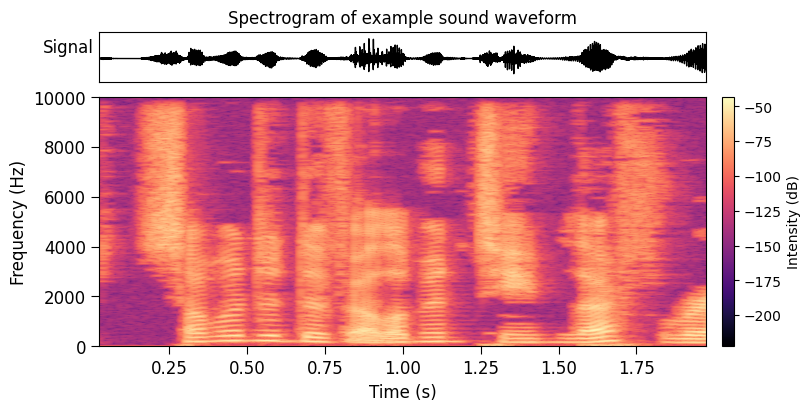

In [25]:
"""
The provided `utils` module contains helper functions for manipulating
and visualizing audio signals. Use the `utils.make_spectrogram_plot` to
plot the sound waveform and spectrogram of the file loaded above.
"""

fig, ax = utils.make_spectrogram_plot(
    x,
    sr,
    figsize=(8, 4),
    # nfft=512,
    str_title="Spectrogram of example sound waveform",
)
plt.show()


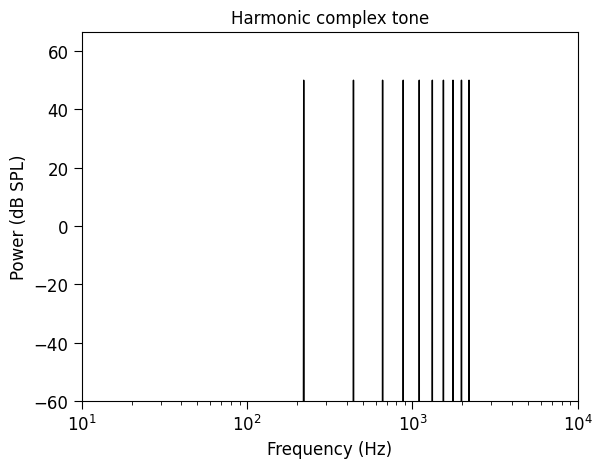

In [26]:
"""
The `utils` module also contains helper functions for generating
simple audio signals. Here, we generate a harmonic complex tone
and plot its power spectrum.
"""

sr = 20e3
x = utils.harmonic_complex_tone(
    sr=sr,
    dur=0.5,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 11),
    amplitudes=1,
)
x = utils.set_dbspl(x, 60.0)

ipd.display(ipd.Audio(rate=sr, data=x))

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(x, sr=sr, scaling="spectrum")
ax.plot(fxx, pxx, color="k", lw=1)
ax = utils.format_axes(
    ax,
    str_title="Harmonic complex tone",
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
    xscale="log",
    yscale="linear",
    xlimits=[10, sr / 2],
    ylimits=[-60, None],
)
plt.show()

# fig, ax = utils.make_periodogram_plot(x, sr, str_title="Harmonic complex tone")
# plt.show()


In [27]:
"""
So far, we have been considering sound waveforms as NumPy arrays, which are
the fundamental datatype for numerical processing in Python. The fundamental
datatype for PyTorch is the tensor. Tensors are similar to NumPy arrays, but
include support for GPU-acceleration and automatic differentiation.
Converting between NumPy arrays and Torch tensors is easy, but requires some
attention to device placement and datatypes.

The PyTorch documentation contains additional information about tensors:
https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html
"""

impulse_numpy = np.zeros(int(1.0 * sr)) # Initialize 1 second of zeros
impulse_numpy[0] = 1 # Set the first value to be 1 to make an impulse

# When defining a tensor, it is good practice to specify the device and the datatype
impulse_torch = torch.as_tensor(impulse_numpy, device=device, dtype=torch.float32)
print(impulse_torch)

impulse_torch.detach().cpu().numpy() # Convert a tensor to a NumPy array


tensor([1., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [28]:
"""
Tensors can be be processed with PyTorch functions and modules. In the
`modules.py` script, I have implemented a `GammatoneFilterbank` class,
which we will use as the first stage of our simple auditory nerve model.

Because PyTorch is designed for parallel numerical processing, this
filterbank (like most models in PyTorch) expects batched rather than
single inputs:
    x.shape = [time] <-- single input sound waveform
    x.shape = [batch, time] <-- batch of input sound waveforms

To run a single sound waveform through a model, simply add a batch axis:
    x = torch.zeros(n) <-- has shape [n]
    x = x[None, ...] <-- has shape [1, n]

Alternatively to this odd `[None, ...]` notation, you can use unsqueeze:
    x = torch.zeros(n) <-- has shape [n]
    x = x.unsqueeze(dim=0) <-- has shape [1, n]
"""

# Construct a filterbank object with specified parameters
filterbank = modules.GammatoneFilterbank(
    sr=sr,
    fir_dur=0.05,
    cfs=utils.erbspace(8e1, 8e3, 50),
    dtype=torch.float32,
    bw_mult=1,
)
# Assign it to a device
filterbank = filterbank.to(device)

# Apply the filterbank to our impulse tensor (note we added a batch axis)
impulse_response_torch = filterbank(impulse_torch[None, ...])
print(impulse_response_torch.shape)
# And remove the added batch axis to get an output with shape [freq, time]
impulse_response_torch = impulse_response_torch[0, ...]
print(impulse_response_torch.shape)


torch.Size([1, 50, 20000])
torch.Size([50, 20000])


(50, 20000)


/rdma/vast-rdma/vast/mcdermott/msaddler/coursework/auditory_model_tutorial/utils.py:99: RuntimeWarning: divide by zero encountered in log10
  pxx = 10.0 * np.log10(pxx / np.square(p_ref))


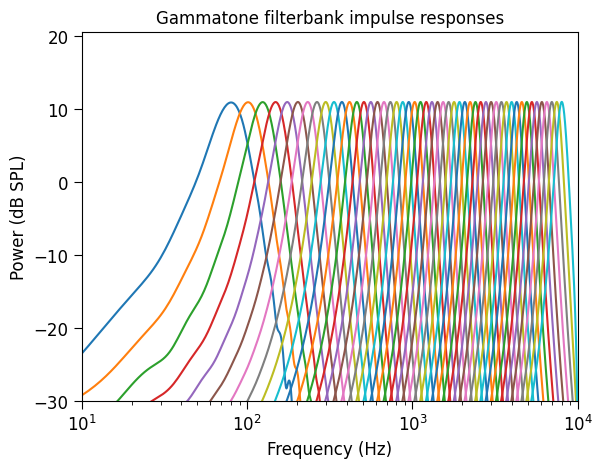

In [29]:
"""
Plot the power spectra of the filterbank's impulse responses.
The provided `utils.make_periodogram_plot` will plot the power
spectrum of each frequency channel if the input is provided
with shape [frequency_channels, time].
"""

# First, convert the impulse response tensor to a NumPy array
impulse_response = impulse_response_torch.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Gammatone filterbank impulse responses",
    ylimits=[-30, None],
)
plt.show()


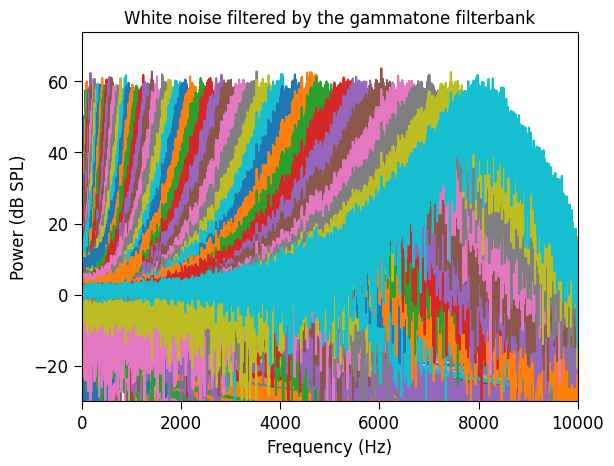

In [30]:
"""
This linear filterbank approximates the cochlea's frequency selectivity.
The input represents the instantaneous pressure of a sound waveform and the
output represents the instantaneous displacement of the basilar membrane 
at different points along its length (the "cochlear frequency axis").

We can pass arbitrary sounds through this filterbank. Here, we filter
white noise and plot the power spectra of the resulting subbands.
"""

x = torch.randn(1, int(sr), device=device, dtype=torch.float32)
y = filterbank(x)[0].detach().cpu().numpy()

fig, ax = utils.make_periodogram_plot(
    y,
    sr,
    str_title="White noise filtered by the gammatone filterbank",
    ylimits=[-30, None],
    xlimits=[0, sr / 2],
    xscale="linear",
)
plt.show()


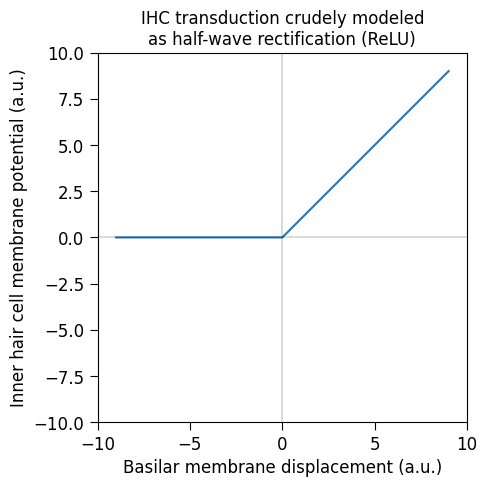

In [31]:
"""
The next stage of our peripheral auditory model is a very crude model of
inner hair cell transduction. Here, we simply use half-wave rectification
to abstractly convert basilar membrane displacement to inner hair cell
membrane potential.

In NumPy / Matlab, half-wave rectification is easily implemented as:
    x[x < 0] = 0  or  x = max(x, 0)
In PyTorch, to avoid disrupting gradient tracking, we will use the
provided "rectified linear unit" class `torch.nn.ReLU`.
"""

half_wave_rectification = torch.nn.ReLU()
x = np.arange(-9, 10)
y = half_wave_rectification(torch.as_tensor(x)).detach().cpu().numpy()

fig, ax = plt.subplots()
ax.plot(x, y)
ax.axvline(0, color="k", lw=0.2)
ax.axhline(0, color="k", lw=0.2)
ax.axis("square")
utils.format_axes(
    ax,
    xlimits=[-10, 10],
    ylimits=[-10, 10],
    str_xlabel="Basilar membrane displacement (a.u.)",
    str_ylabel="Inner hair cell membrane potential (a.u.)",
    str_title="IHC transduction crudely modeled\nas half-wave rectification (ReLU)",
)
plt.show()


(20000,)


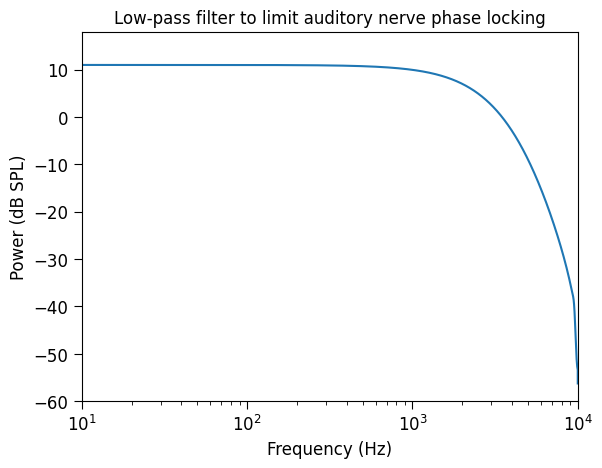

In [32]:
"""
Next, we apply a low-pass filter to the half-wave rectified subbands.
This filter models the sluggishness of the inner hair cell membrane
potential, which cannot oscillate as quickly the basilar membrane.
This low-pass filter limits the temporal resolution of downstream
auditory nerve fiber spiking (i.e., frequency limit of phase locking).

Here we plot the filter's impulse response. The `modules.IHCLowpassFilter`
module operates on inputs with shape [batch, time] or [batch, freq, time].
In the latter case, the same filter will be applied along the time axis to
each frequency channel.
"""

ihc_lowpass_filter = modules.IHCLowpassFilter(
    sr_input=sr,
    sr_output=sr,
    fir_dur=0.05,
    cutoff=3e3,
    order=7,
).to(device)

impulse_response_torch = ihc_lowpass_filter(impulse_torch[None, ...])[0]
impulse_response = impulse_response_torch.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Low-pass filter to limit auditory nerve phase locking",
)
plt.show()


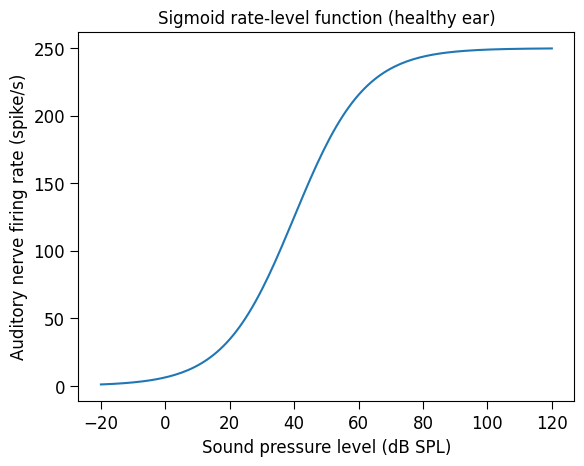

In [33]:
"""
The last stage of the simple peripheral model will convert the half-wave
rectified and low-pass filtered subbands to instantaneous auditory nerve
firing rates. This is accomplished with a sigmoid function whose threshold
and dynamic range can be set in dB SPL. Applying a sigmoid function at the
output lets us crudely model loss of audibility at low sound levels and
saturation at high sound levels.

The parameters of this rate-level function are somewhat arbitrary and 
ignore much of the complexity of real auditory nerve fibers. Here, we
will make some simplifying (and incorrect) assumptions about healthy
auditory nerve fibers:
- Threshold = 0 dB SPL
- Dynamic range = 80 dB
- Spontaneous activity = 0 spikes/s
- Maximum activity = 250 spikes/s
"""

fig, ax = plt.subplots()
rate_level_function = modules.SigmoidRateLevelFunction(
    rate_spont=0.0,
    rate_max=250.0,
    threshold=0.0,
    dynamic_range=80.0,
    dynamic_range_interval=0.95,
    dtype=torch.float32,
).to(device)
x_db = np.arange(-20, 121)
x_pa = 20e-6 * (10 ** (x_db / 20))
x_pa_torch = torch.as_tensor(
    x_pa,
    device=device,
    dtype=torch.float32,
)
y_torch = rate_level_function(x_pa_torch[None, None, :])[0, 0, :]
y = y_torch.detach().cpu().numpy()
ax.plot(x_db, y)
ax = utils.format_axes(
    ax,
    str_xlabel="Sound pressure level (dB SPL)",
    str_ylabel="Auditory nerve firing rate (spike/s)",
    str_title="Sigmoid rate-level function (healthy ear)",
)
plt.show()


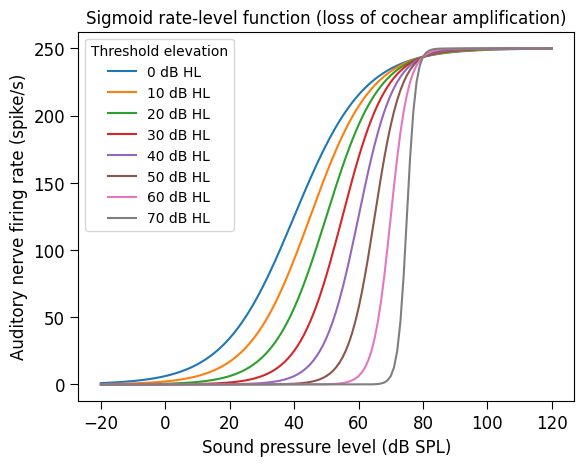

In [72]:
"""
In the healthy ear, outer hair cells (OHCs) act as a cochlear amplifier,
boosting responses to quiet sounds. Sensorineural hearing loss often
involves the death or dysfunction of OHCs, resulting in elevated thresholds
and a reduced dynamic range. We can simulate these effects by adjusting
the rate-level function parameters.
"""

fig, ax = plt.subplots()
healthy_threshold = 0.0
healthy_dynamic_range = 80.0
for dbhl in np.arange(0, 75, 10):
    rate_level_function = modules.SigmoidRateLevelFunction(
        rate_spont=0.0,
        rate_max=250.0,
        threshold=healthy_threshold + dbhl,
        dynamic_range=healthy_dynamic_range - dbhl,
        dtype=torch.float32,
    ).to(device)
    x_db = np.arange(-20, 121)
    x_pa = 20e-6 * (10 ** (x_db / 20))
    x_pa_torch = torch.as_tensor(
        x_pa,
        device=device,
        dtype=torch.float32,
    )
    y_torch = rate_level_function(x_pa_torch[None, None, :])[0, 0, :]
    y = y_torch.detach().cpu().numpy()
    ax.plot(x_db, y, label=f"{dbhl} dB HL")
ax.legend(title="Hearing loss")
ax = utils.format_axes(
    ax,
    str_xlabel="Sound pressure level (dB SPL)",
    str_ylabel="Auditory nerve firing rate (spike/s)",
    str_title="Sigmoid rate-level function (loss of cochear amplification)",
)
plt.show()


In [35]:
"""
Now that we have examined each of the cochlear model stages individually,
it is time to assemble the full cochlear model into a single torch Module.

A skeleton for the `CochlearModel` class is provided below. If you are
familiar with Python classes, you will notice the skeleton is subclassing
the `torch.nn.Module` class. This class is the base class for all models in
PyTorch (https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

Because our model is a subclass of `torch.nn.Module`, we only need to
implement two methods (`__init__` and `forward`) to obtain a functioning
PyTorch model. The `__init__` method sets up the model and is where you
should define each of the model components. The `forward` method defines
the computations that should be performed each time the model is called.
Here, the `forward` pass should successively apply the model components
defined in the `__init__` method.

The convenience of PyTorch is that if we want to compute gradients from
or through our model, we do not need to implement that `backward` pass
ourselves. The derivatives will all be computed / tracked automatically!
"""

class CochlearModel(torch.nn.Module):
    def __init__(
        self,
        sr_input=20000,
        sr_output=10000,
        fir_dur=0.05,
        cfs=utils.erbspace(8e1, 8e3, 100),
        bw_mult=1.0,
        threshold=0.0,
        dynamic_range=80.0,
        dtype=torch.float32,
    ):
        """
        Simple cochlear model in PyTorch.

        Args
        ----
        sr_input (int): sampling rate of the input sound waveform
        sr_output (int): sampling rate of the output representation
        fir_dur (float): duration of finite impulse responses for filtering (s)
        cfs (np.ndarray): characteristic frequencies of the cochlear filters (Hz)
        bw_mult (float): scales cochlear filter bandwidths
        threshold (float): absolute threshold of auditory nerve fibers (dB SPL)
        dynamic_range (float): auditory nerve fiber dynamic range (dB)
        dtype (torch.dtype): datatype for internal intensors and inputs
        """
        super().__init__()
        self.sr_input = sr_input
        self.sr_output = sr_output
        self.cfs = cfs
        self.cochlear_filterbank = modules.GammatoneFilterbank(
            sr=sr_input,
            fir_dur=fir_dur,
            cfs=self.cfs,
            dtype=dtype,
            bw_mult=bw_mult,
        )
        self.half_wave_rectification = torch.nn.ReLU()
        self.ihc_lowpass_filter = modules.IHCLowpassFilter(
            sr_input=sr_input,
            sr_output=sr_output,
            fir_dur=fir_dur,
            cutoff=3e3,
            order=7,
        )
        self.rate_level_function = modules.SigmoidRateLevelFunction(
            rate_spont=0.0,
            rate_max=250.0,
            threshold=threshold,
            dynamic_range=dynamic_range,
            dynamic_range_interval=0.95,
            dtype=dtype,
        )

    def forward(self, x):
        """
        Run the cochlear model on an input sound waveform.

        Args
        ----
        x (torch.Tensor): input sound waveform with shape [batch, time]

        Returns
        -------
        x (torch.Tensor): output of cochlear model with shape [batch, freq, time]
        """
        x = self.cochlear_filterbank(x)
        x = self.half_wave_rectification(x)
        x = self.ihc_lowpass_filter(x)
        x = self.half_wave_rectification(x)
        x = self.rate_level_function(x)
        return x


(100, 500)


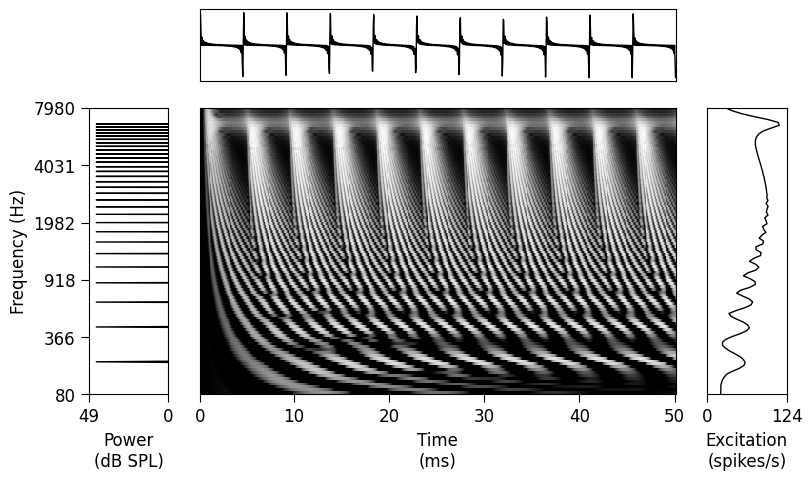

In [36]:
"""
Test the cochlear model implementation with this cell.

(1) Construct a cochlear_model object with a call to the `CochlearModel` class
(2) Generate or load a sound waveform `x`
(3) Convert `x` to a tensor with shape [batch=1, time]
(3) Apply cochlear_model to `x` to produce `x_nervegram` [batch=1, freq, time]
(4) Convert `x_nervegram` to a NumPy array with shape [freq, time]
(5) Visualize `x_nervegram` using `utils.make_nervegram_plot`
"""

cochlear_model = CochlearModel(
    sr_input=20e3,
    sr_output=10e3,
    cfs=utils.erbspace(8e1, 8e3, 100),
).to(device)

x = utils.harmonic_complex_tone(
    sr=cochlear_model.sr_input,
    dur=0.05,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 31, 1),
)
# x, _ = sf.read("data/000.wav")
x = utils.set_dbspl(x, 60)

x_tensor = torch.as_tensor(x, device=device).float()[None, ...]
x_nervegram_tensor = cochlear_model(x_tensor)[0]
x_nervegram = x_nervegram_tensor.detach().cpu().numpy()
print(x_nervegram.shape)

fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram,
    sr_waveform=cochlear_model.sr_input,
    sr_nervegram=cochlear_model.sr_output,
    cfs=cochlear_model.cfs,
)
plt.show()


In [37]:
"""
Get a sense for how fast the cochlear model can run on the current device.
"""
progress_bar = tqdm.tqdm(range(20)) # tqdm.tqdm wraps an iterable and displays a progress bar
for itr in progress_bar:
    x_nervegram_tensor = cochlear_model(x_tensor)
    progress_bar.set_postfix({"current_iteration": itr})


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1275.23it/s, current_iteration=19]


Healthy cochlear model


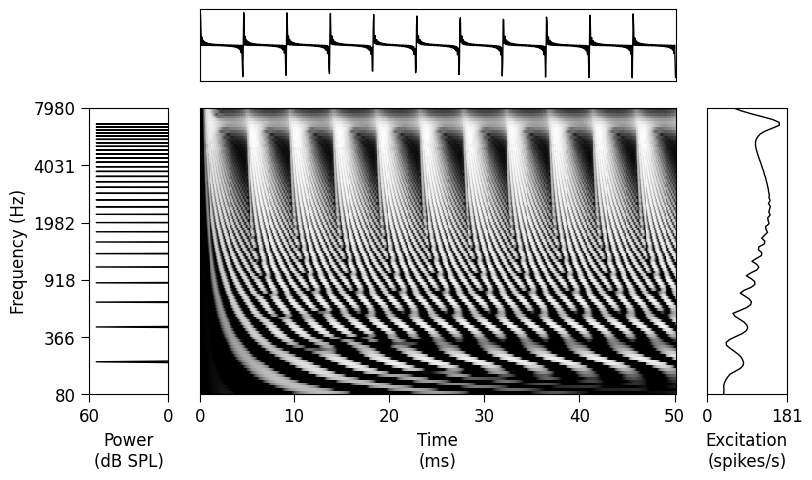

Impaired cochlear model


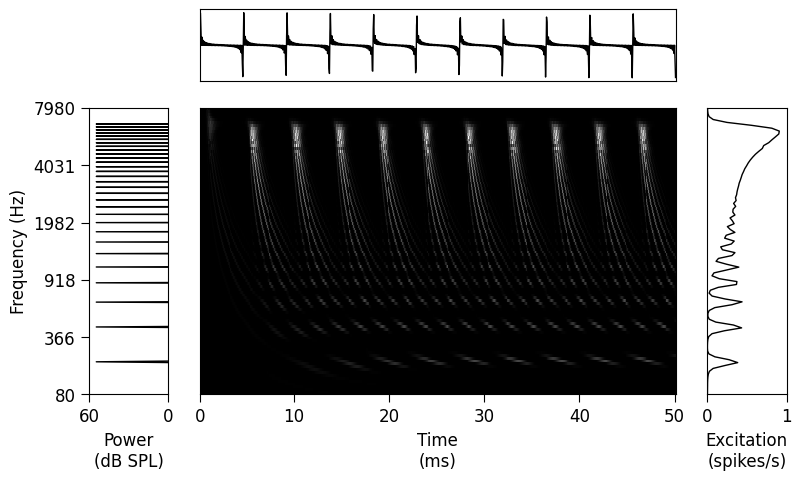

In [75]:
"""
Visualize the effect of hearing loss on the
simulated auditory nerve representations.
"""
cfs = utils.erbspace(8e1, 8e3, 100)

# Construct a healthy cochlear model
cochlear_model_healthy = CochlearModel(
    sr_input=sr,
    cfs=cfs,
    threshold=0.0,
    dynamic_range=80.0,
).to(device)

# Construct an impaired cochlear model
cochlear_model_impaired = CochlearModel(
    sr_input=sr,
    cfs=cfs,
    threshold=60.0,
    dynamic_range=20.0,
).to(device)

# Define a stimulus to play to both cochlear models
x = utils.harmonic_complex_tone(
    sr=cochlear_model_healthy.sr_input,
    dur=0.05,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 31, 1),
)
x = utils.set_dbspl(x, 70)

# Run the stimulus through both cochlear models
x_tensor = torch.as_tensor(x, device=device, dtype=torch.float32)[None, ...]
x_nervegram_healthy = cochlear_model_healthy(x_tensor)[0].detach().cpu().numpy()
x_nervegram_impaired = cochlear_model_impaired(x_tensor)[0].detach().cpu().numpy()

# Visualize both auditory nerve representations
print("Healthy cochlear model")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_healthy,
    sr_waveform=cochlear_model_healthy.sr_input,
    sr_nervegram=cochlear_model_healthy.sr_output,
    cfs=cochlear_model_healthy.cfs,
)
plt.show()
print("Impaired cochlear model")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_impaired,
    sr_waveform=cochlear_model_healthy.sr_input,
    sr_nervegram=cochlear_model_healthy.sr_output,
    cfs=cochlear_model_healthy.cfs,
)
plt.show()


In [76]:
"""
A reasonable objective for a hearing aid would be to process audio
in such a way that the auditory nerve representation of an impaired
ear is maximally similar to that of a healthy ear. How can we
implement this notion quantitatively, as a loss function?

x <-- unprocessed sound waveform
x_aided = hearing_aid(x)
y_healthy = cochlear_model_healthy(x)
y_impaired = cochlear_model_impaired(x_aided)
Goal: minimize distance_between(y_healthy, y_impaired)

Some of the useful PyTorch loss functions include:
    torch.nn.functional.mse_loss
    torch.nn.functional.l1_loss
(https://pytorch.org/docs/stable/nn.functional.html#loss-functions)
"""

def loss_function(x, x_aided):
    y_healthy = cochlear_model_healthy(x)
    y_impaired = cochlear_model_impaired(x_aided)
    loss = torch.nn.functional.mse_loss(y_impaired, y_healthy)
    return loss


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1076.90it/s]


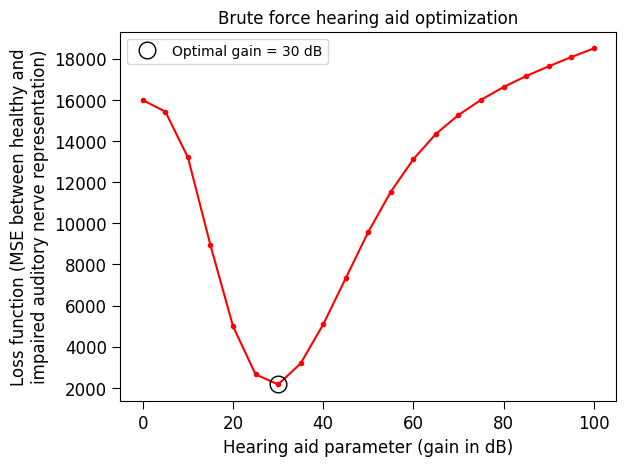

In [81]:
"""
We will first consider the simplest possible hearing aid: 
linear amplification applied to the entire sound waveform.

Here there is just one parameter to optimize (the gain), so
we can easily find the optimal value with brute force.
"""
list_db_gain = np.arange(0, 101, 5)
list_loss = []
for db_gain in tqdm.tqdm(list_db_gain):
    amp = np.power(10, db_gain / 20)
    loss = loss_function(
        x=x_tensor,
        x_aided=amp * x_tensor,
    ).item()
    list_loss.append(loss)

best_db_gain = list_db_gain[np.argmin(list_loss)]

fig, ax = plt.subplots()
ax.plot(list_db_gain, list_loss, marker=".", color="r", ls="-")
ax.plot(
    best_db_gain,
    np.min(list_loss),
    marker="o",
    ms=12,
    ls="",
    mfc="none",
    color="k",
    label=f"Optimal gain = {best_db_gain} dB",
)
ax.legend()
utils.format_axes(
    ax,
    str_title="Brute force hearing aid optimization",
    str_xlabel="Hearing aid parameter (gain in dB)",
    str_ylabel="Loss function (MSE between healthy and\nimpaired auditory nerve representation)",
)
plt.show()


Healthy cochlear model with unprocessed input


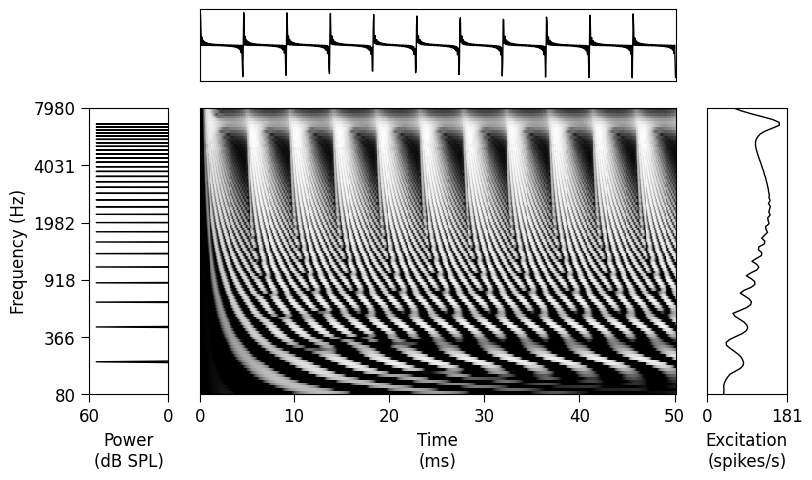

Impaired cochlear model with aided input


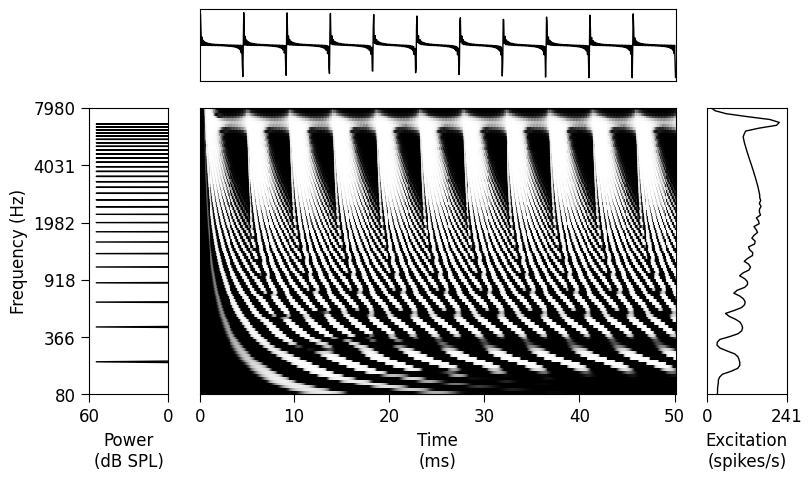

In [41]:
"""
Visualize the resulting auditory nerve representations.
"""
best_amp = np.power(10, best_db_gain / 20)

x_tensor = torch.as_tensor(x, device=device, dtype=torch.float32)[None, ...]
x_nervegram_healthy = cochlear_model_healthy(x_tensor)[0].detach().cpu().numpy()
x_nervegram_impaired = cochlear_model_impaired(best_amp * x_tensor)[0].detach().cpu().numpy()

print("Healthy cochlear model with unprocessed input")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_healthy,
    sr_waveform=cochlear_model_healthy.sr_input,
    sr_nervegram=cochlear_model_healthy.sr_output,
    cfs=cochlear_model_healthy.cfs,
)
plt.show()
print("Impaired cochlear model with aided input")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_impaired,
    sr_waveform=cochlear_model_impaired.sr_input,
    sr_nervegram=cochlear_model_impaired.sr_output,
    cfs=cochlear_model_impaired.cfs,
)
plt.show()


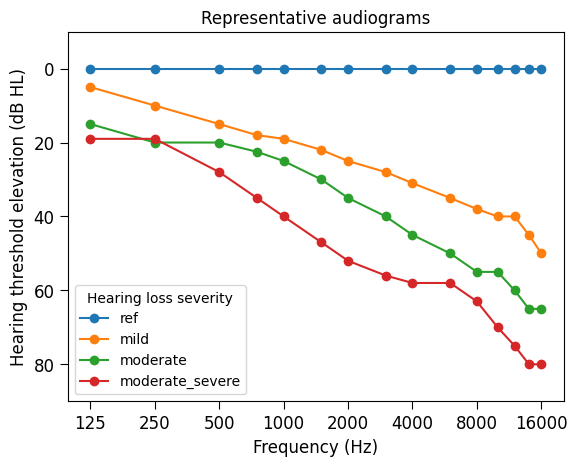

In [56]:
"""
Real hearing losses are rarely uniform across all frequencies.
How can we compensate for a more plausible frequency-dependent
hearing loss?
"""

fig, ax = plt.subplots()
for severity in ["ref", "mild", "moderate", "moderate_severe"]:
    freq, dbhl = utils.get_example_audiogram(severity)
    ax.plot(freq, dbhl, marker="o", label=severity)
ax.legend(title="Hearing loss severity")
ax = utils.format_axes(
    ax,
    xscale="log",
    ylimits=[90, -10],
    xticks=[125, 250, 500, 1000, 2000, 4000, 8000, 16000],
    xticklabels=[125, 250, 500, 1000, 2000, 4000, 8000, 16000],
    xticks_minor=[],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Hearing threshold elevation (dB HL)",
    str_title="Representative audiograms",
)
plt.show()


cfs.shape=(100,), threshold.shape=(100,), dynamic_range.shape=(100,)


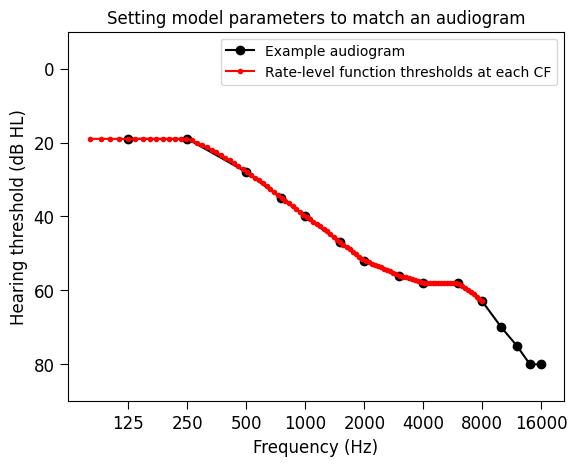

In [85]:
"""
Construct a new impaired cochlear model that better approximates
a realistic hearing-impaired audiogram. Here we set the model's
`threshold` and `dynamic_range` as frequency-specific arrays with
the same shape as `cfs`.
"""

freq, dbhl = utils.get_example_audiogram(severity="moderate_severe")
threshold, dynamic_range = utils.map_audiogram_to_rate_level_parameters(
    freq=freq,
    dbhl=dbhl,
    cfs=cfs,
    healthy_threshold=healthy_threshold,
    healthy_dynamic_range=healthy_dynamic_range,
)
print(f"{cfs.shape=}, {threshold.shape=}, {dynamic_range.shape=}")
cochlear_model_impaired = CochlearModel(
    sr_input=sr,
    cfs=cfs,
    threshold=threshold,
    dynamic_range=dynamic_range,
).to(device)

fig, ax = plt.subplots()
ax.plot(freq, dbhl, marker="o", color="k", label="Example audiogram")
ax.plot(
    cochlear_model_impaired.cfs,
    cochlear_model_impaired.rate_level_function.threshold,
    marker=".",
    color="r",
    label="Rate-level function thresholds at each CF",
)
ax.legend()
ax = utils.format_axes(
    ax,
    xscale="log",
    ylimits=[90, -10],
    xticks=[125, 250, 500, 1000, 2000, 4000, 8000, 16000],
    xticklabels=[125, 250, 500, 1000, 2000, 4000, 8000, 16000],
    xticks_minor=[],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Hearing threshold (dB HL)",
    str_title="Setting model parameters to match an audiogram",
)
plt.show()


(7, 20000)


/rdma/vast-rdma/vast/mcdermott/msaddler/coursework/auditory_model_tutorial/modules.py:248: RuntimeWarning: divide by zero encountered in log
  f = np.log(f)


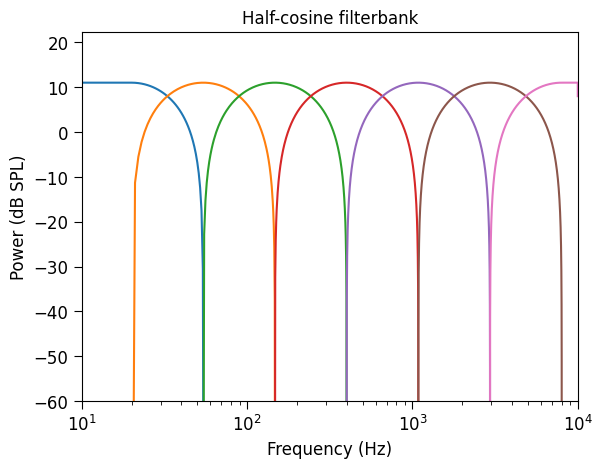

In [86]:
"""
One possibility is to build a hearing aid with frequency-specific
gains. We can filter the input sound into different frequency
channels, scale the channels with separate gains, and then sum
the channels back together.
"""

filterbank = modules.HalfCosineFilterbank(
    sr=sr,
    cf_low=20,
    cf_high=8000,
    cf_num=7,
    scale="log",
    include_highpass=True,
    include_lowpass=True,
).to(device)

impulse_response_torch = filterbank(impulse_torch[None, ...])[0]
impulse_response = impulse_response_torch.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Half-cosine filterbank",
)
plt.show()


HearingAid(
  (filterbank): HalfCosineFilterbank()
)
gains Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True)


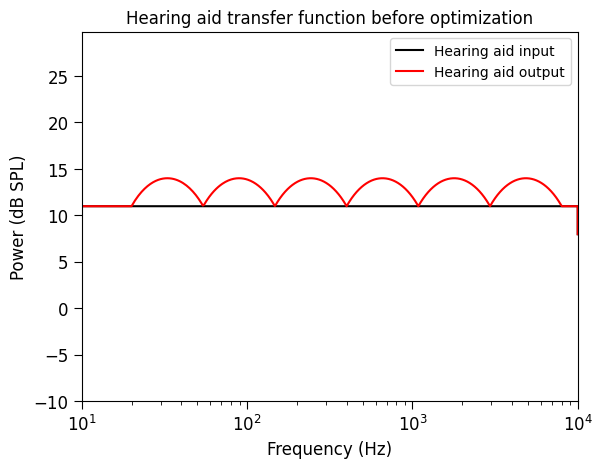

In [87]:
"""
Such a hearing aid would have multiple tunable parameters, and the brute
force method of finding optimal values rapidly becomes intractable. We
will instead construct the hearing aid as a PyTorch model with learnable
parameters. We can then use gradient descent to efficiently find values
that minimize our loss function.
"""

class HearingAid(torch.nn.Module):
    def __init__(self, sr=20e3):
        """
        Initialize the hearing aid model.
        """
        super().__init__()
        self.filterbank = modules.HalfCosineFilterbank(
            sr=sr,
            cf_low=20,
            cf_high=8000,
            cf_num=7,
            scale="log",
            include_highpass=True,
            include_lowpass=True,
        )
        self.gains = torch.nn.parameter.Parameter(
            data=torch.zeros(self.filterbank.cf_num),
            requires_grad=True,
        )

    def forward(self, x):
        """
        Apply the computations to an input sound `x`.
        """
        y = self.filterbank(x)
        y = y * torch.pow(10, self.gains / 20).view(1, -1, 1)
        y = torch.sum(y, axis=1)
        return y


hearing_aid = HearingAid(sr=sr).to(device)
# hearing_aid.gains = torch.nn.Parameter(5 * torch.randn(*hearing_aid.gains.shape))
print(hearing_aid)
for n, p in hearing_aid.named_parameters():
    print(n, p if p.ndim == 1 else p.shape)

impulse_response_torch = hearing_aid(impulse_torch[None, ...])[0]
impulse_response = impulse_response_torch.detach().cpu().numpy()

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(impulse_numpy, sr)
fyy, pyy = utils.periodogram(impulse_response, sr)
ax.plot(fxx, pxx, color="k", label="Hearing aid input")
ax.plot(fyy, pyy, color="r", label="Hearing aid output")
ax.legend()
utils.format_axes(
    ax,
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[-10, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
    str_title="Hearing aid transfer function before optimization",
)
plt.show()


In [88]:
"""
Optimize the parameters of the hearing aid via gradient descent.

This cell will run extremely slowly without GPU acceleration.
If a GPU is not available, use a smaller dataset by truncating
the number of examples and/or the length of the stimuli.
"""

# Define the dataset (for time, we use only a small batch of speech signals)
x = np.stack(
    [sf.read("data/{:03d}.wav".format(_))[0] for _ in range(1)],
    axis=0,
)
x = torch.as_tensor(x, device=device, dtype=torch.float32)
print(f"Dataset shape: {x.shape}")

# Define a PyTorch optimizer object and tell it which parameters to update
optimizer = torch.optim.Adam(
    params=list(hearing_aid.parameters()),
    lr=1e-1,  # The learning rate is a hyperparameter (determines gradient descent step size)
)

# In the optimization loop, we iteratively compute the loss,
# calculate the gradients with `loss.backward()`, and then
# call `optimizer.step()` to update the parameters.
progress_bar = tqdm.tqdm(range(500))
for step in progress_bar:
    optimizer.zero_grad()
    x_aided = hearing_aid(x)
    loss = loss_function(x=x, x_aided=x_aided)
    loss.backward()
    optimizer.step()
    progress_bar.set_postfix({"loss": "{:0.4f}".format(loss.item())})

print("hearing_aid parameters after optimization:")
for n, p in hearing_aid.named_parameters():
    print(n, p if p.ndim == 1 else p.shape)


Dataset shape: torch.Size([1, 40000])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 63.93it/s, loss=378.9854]

hearing_aid parameters after optimization:
gains Parameter containing:
tensor([ 3.7656,  6.2263,  7.7691,  9.2437, 19.4065, 28.4120, 34.6770],
       device='cuda:0', requires_grad=True)


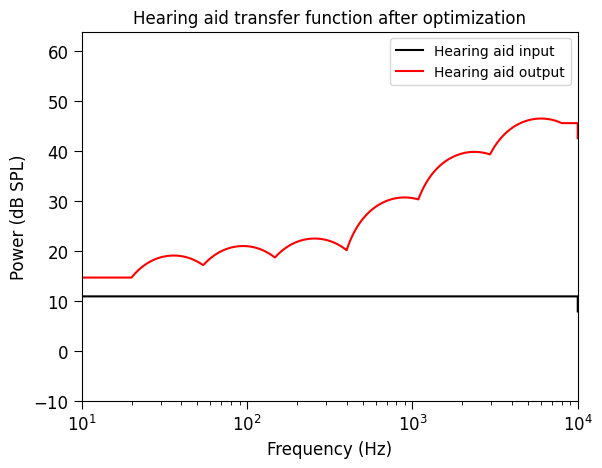

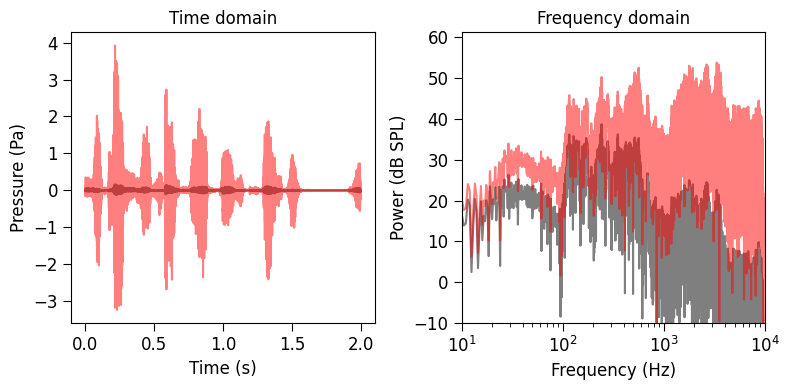

In [89]:
"""
Visualize the optimized hearing aid's signal processing.
"""

impulse_response_torch = hearing_aid(impulse_torch[None, ...])[0]
impulse_response = impulse_response_torch.detach().cpu().numpy()

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(impulse_numpy, sr)
fyy, pyy = utils.periodogram(impulse_response, sr)
ax.plot(fxx, pxx, color="k", label="Hearing aid input")
ax.plot(fyy, pyy, color="r", label="Hearing aid output")
ax.legend()
utils.format_axes(
    ax,
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[-10, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
    str_title="Hearing aid transfer function after optimization",
)
plt.show()

example_audio = torch.as_tensor(
    sf.read("data/000.wav".format(_))[0][None, :],
    device=device,
    dtype=torch.float32,
)

example_audio_aided = hearing_aid(example_audio)
example_audio = example_audio[0].detach().cpu().numpy()
example_audio_aided = example_audio_aided[0].detach().cpu().numpy()

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
t = np.arange(0, len(example_audio)) / sr
ax_arr[0].plot(t, example_audio, color="k", alpha=0.5)
ax_arr[0].plot(t, example_audio_aided, color="r", alpha=0.5)
ax_arr[0] = utils.format_axes(
    ax_arr[0],
    str_xlabel="Time (s)",
    str_ylabel="Pressure (Pa)",
    str_title="Time domain",
)
fxx, pxx = utils.periodogram(example_audio, sr)
fyy, pyy = utils.periodogram(example_audio_aided, sr)
ax_arr[1].plot(fxx, pxx, color="k", alpha=0.5)
ax_arr[1].plot(fyy, pyy, color="r", alpha=0.5)
ax_arr[1] = utils.format_axes(
    ax_arr[1],
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[-10, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
    str_title="Frequency domain",
)
plt.tight_layout()
plt.show()

ipd.display(ipd.Audio(rate=sr, data=example_audio))
ipd.display(ipd.Audio(rate=sr, data=example_audio_aided))


Healthy cochlear model with unprocessed input


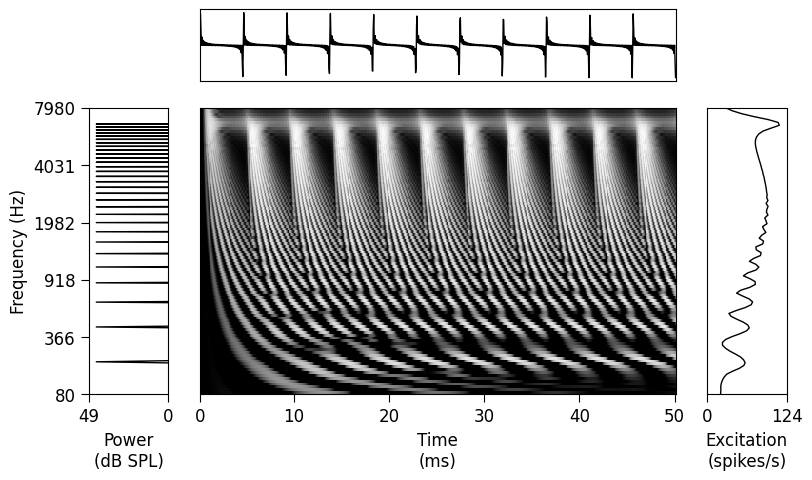

Impaired cochlear model with unprocessed input


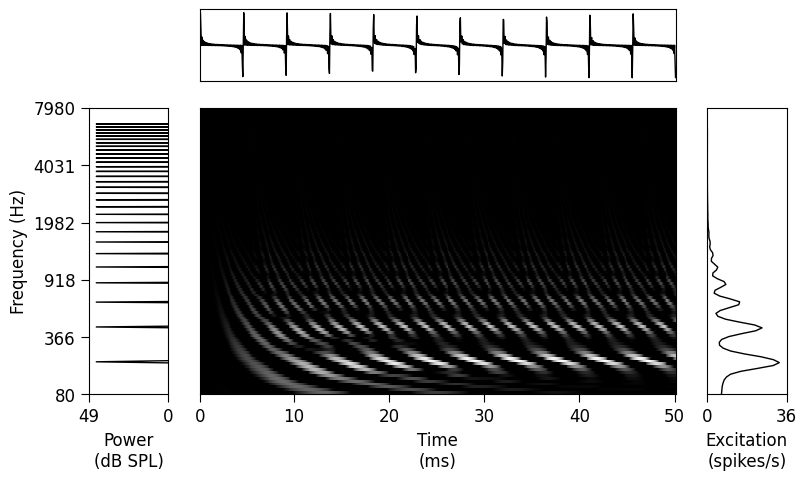

Impaired cochlear model with aided input


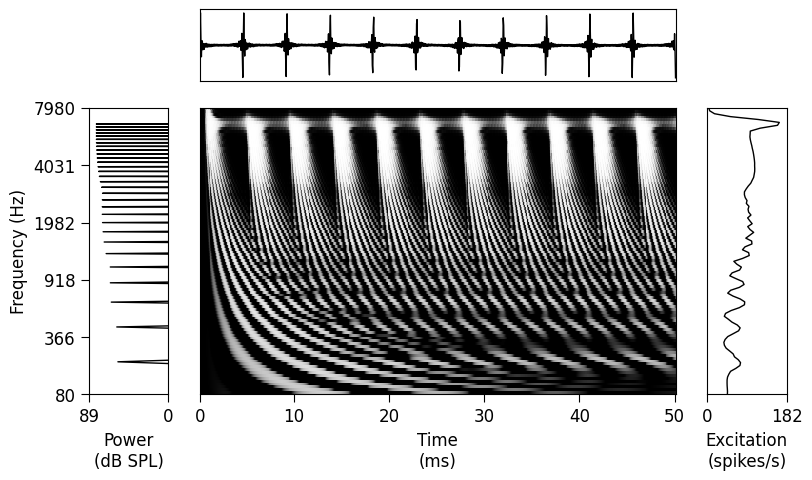

In [90]:
"""
Visualize the resulting auditory nerve representations.
"""

x = utils.harmonic_complex_tone(
    sr=sr,
    dur=0.05,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 31),
)
x = utils.set_dbspl(x, 60.0)
# x, _ = sf.read("data/000.wav")

x = torch.as_tensor(x[None, ...], device=device, dtype=torch.float32)
x_aided = hearing_aid(x)
x_nervegram_healthy = cochlear_model_healthy(x)[0].detach().cpu().numpy()
x_nervegram_impaired = cochlear_model_impaired(x)[0].detach().cpu().numpy()
x_nervegram_impaired_aided = cochlear_model_impaired(x_aided)[0].detach().cpu().numpy()
x = x[0].detach().cpu().numpy()
x_aided = x_aided[0].detach().cpu().numpy()

print("Healthy cochlear model with unprocessed input")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_healthy,
    sr_waveform=cochlear_model_healthy.sr_input,
    sr_nervegram=cochlear_model_healthy.sr_output,
    cfs=cochlear_model_healthy.cfs,
)
plt.show()
print("Impaired cochlear model with unprocessed input")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram_impaired,
    sr_waveform=cochlear_model_impaired.sr_input,
    sr_nervegram=cochlear_model_impaired.sr_output,
    cfs=cochlear_model_impaired.cfs,
)
plt.show()
print("Impaired cochlear model with aided input")
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x_aided,
    nervegram=x_nervegram_impaired_aided,
    sr_waveform=cochlear_model_impaired.sr_input,
    sr_nervegram=cochlear_model_impaired.sr_output,
    cfs=cochlear_model_impaired.cfs,
)
plt.show()
